In [1]:
import torch
import torch.nn as nn
import torch.optim  as optim
import torchvision

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from utils.utils import *
os.environ['KMP_DUPLICATE_LIB_OK']='True' # add this, otherwise the model will easily died because of plt
%matplotlib inline
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# load samples from ImageNet
data = np.load("./src/imagenet_val_25.npz", allow_pickle=True)
imgs = data["X"]
labels = data["y"]
map = data["label_map"]
map = map.tolist()
print(f"sample image num: {imgs.shape[0]}")

sample image num: 25


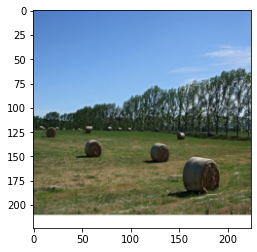

In [3]:
plt.imshow(imgs[0])

In [6]:
# squeeze net is more efficient and more fast
model = torchvision.models.squeezenet1_1(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

## how to fool a model ?

given a cat image, we can still do gradient ascent on class (eg:dog) to maximize the probabilty that model think the image is a dog, you may think: the image must be totally different to make it a dog, however, we, human can not tell the different between img and modified img.

In [8]:
# fool model
def fool_model(input_img, target_cls, model):
    softmax = torch.nn.Softmax(dim=1)
    num_iter = 100

    # preprocess input img
    img = preprocess(input_img).unsqueeze(0)

    # out is final output
    model.eval()
    out = img.clone()

    for i in range(num_iter):
          img = out.clone()
          img.requires_grad = True
          pred = model(img)
          prob = softmax(pred)

          # check prob of target class
          if i % 10 == 0:
            print(f"target class's prob: {prob[0, target_cls]}")
            if prob[0, target_cls] > 0.95:
                break

          # loss is from pred not prob
          loss = pred[0, target_cls]
          loss.backward()
          grad_data = img.grad.data

          # do gradient ascent
          out += 0.1 * grad_data
    return out

out = fool_model(imgs[0], 5, model)

target class's prob: 7.338535334966423e-10
target class's prob: 6.042184850230115e-07
target class's prob: 0.5540248155593872
target class's prob: 0.9463434815406799
target class's prob: 0.9767855405807495


In [9]:
softmax = torch.nn.Softmax(dim=1)
print(torch.argmax(softmax(model(preprocess(imgs[0]).unsqueeze(0)))))
print(torch.argmax(softmax(model(out))))

tensor(958)
tensor(5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


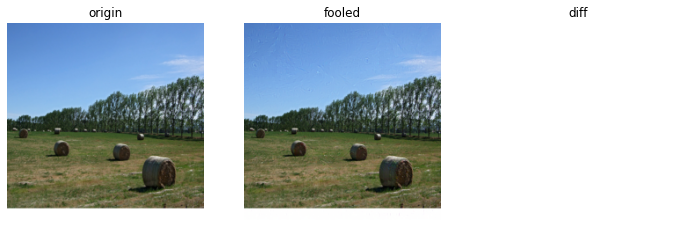

In [18]:
# big difference between reshape and permute
plt.subplot(1,3,1)
plt.imshow(imgs[0])
plt.axis("off")
plt.title("origin")
plt.subplot(1,3,2)
fool_img = out.squeeze(0).permute(1,2,0).numpy() * std + mean
plt.imshow(fool_img)
plt.axis("off")
plt.title("fooled")
plt.subplot(1,3,3)
plt.imshow(abs(imgs[0] - fool_img)*10000)
plt.axis("off")
plt.title("diff")
plt.gcf().set_size_inches(12,5)